# Experiment 1.1: Dataset intial exploration

Dataset selected: [MovieLens Dataset [1M version]](https://grouplens.org/datasets/movielens/1m/).

Dataset README.txt overview: [[1]](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt).

Let's first read the `ratings.dat` file as the main one we should be using in this part of the work and develop a script to read all of the similarly-structured data:

In [2]:
import numpy as np
import pandas as pd
import scipy

In [4]:
!ls ../../data/ml-1m

movies.dat  ratings.dat  README  users.dat


In [5]:
df_ratings = pd.read_csv('../../data/ml-1m/ratings.dat',
                         delimiter='::',
                         header=None,
                         names=['UserID','MovieID','Rating','Timestamp'])

/tmp/ipykernel_99451/3427229333.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ratings = pd.read_csv('../../data/ml-1m/ratings.dat',


In [6]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Converting to a sparce matrix

Let's convert our data into a sparse `scipy` matrix for more efficient evaluation and likely, future statistics computations. We are also likely to do an evaluation framework based on this approach.

**Note:** due to indices in the sparce matrices starting from 0 and the IDs in the data starting from 1, the pairs indices in the sparce matrices will correspond to (`UserID` - 1,`MovieID` - 1).

Let's do the test run on the first 10 rankings:

In [7]:
dict_ratings = df_ratings[['UserID','MovieID','Rating']][:10]

In [8]:
dict_ratings

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
sparse_ratings = scipy.sparse.csr_matrix((dict_ratings['Rating'],
                                          (dict_ratings['UserID'] - 1, dict_ratings['MovieID'] - 1)))

In [11]:
print(sparse_ratings)

  (0, 593)	4
  (0, 660)	3
  (0, 913)	3
  (0, 918)	4
  (0, 1192)	5
  (0, 1196)	3
  (0, 1286)	5
  (0, 2354)	5
  (0, 2803)	5
  (0, 3407)	4


In [12]:
sparse_ratings.shape

(1, 3408)

Here, we test our first user-user comparison metric:

In [13]:
cosine_similarity(sparse_ratings)

array([[1.]])

Which works on this data format.

And then on the entire dataset:

In [14]:
sparse_ratings = scipy.sparse.csr_matrix((df_ratings['Rating'],
                                          (df_ratings['UserID'] - 1, df_ratings['MovieID'] - 1)))

In [15]:
sparse_ratings.shape

(6040, 3952)

Exactly as our data dimensions, which means that we've successfully transformed it.

In [16]:
cosine_similarity(sparse_ratings)

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

So now we now that we have a way to efficiently compute the evaluation metrics. Now we can start the EDA of the whole dataset.

Primarily, we will inspect how the users' rating are similar with each other, and also how similar are the movies rated. Are there any specific groups of users or movies? Are there any relation of the movies ratings to their genres? Are the similar users providing the similar ratings to the movies from the same cluster or genre? Are the users' preferences influenced by their age, gender, occupation, or even location (which we can know from the zip-code in the data)? Are there any geographical anomalies in the ratings? Do the user's preferences and rating change with time? Are there some movies, which average rating changes with time over a moving time period? Do the changes in the way the movies are rated depend om their genre, meaning some of the genres are higher rated in some time periods? Is the data consistent at all, does it have some missing or possibly incorrect values, and should we do anything to clean it?

These are the main questions that we would like to answer with our exploratory data analysis, judging for the dataset infromation available. So, let's do this.

## Ratings analysis

Let’s start by trying to understand whether there are underlying patterns and dependencies in the data. To depict it visually, let’s reduce its dimensions for the users in a meaningful way with PCA:

In [18]:
from sklearn.decomposition import TruncatedSVD

In [19]:
svd = TruncatedSVD(n_components=2,
                   random_state=5)

In [20]:
svd.fit(sparse_ratings)

TruncatedSVD(random_state=5)

In [26]:
print(f'--Explained variance: {svd.explained_variance_ratio_}, total: {svd.explained_variance_ratio_.sum():.5f}')

--Explained variance: [0.1351055  0.03729351], total: 0.17240


In [27]:
ratings_transformed_2 = svd.transform(sparse_ratings)

In [29]:
import matplotlib.pyplot as plt

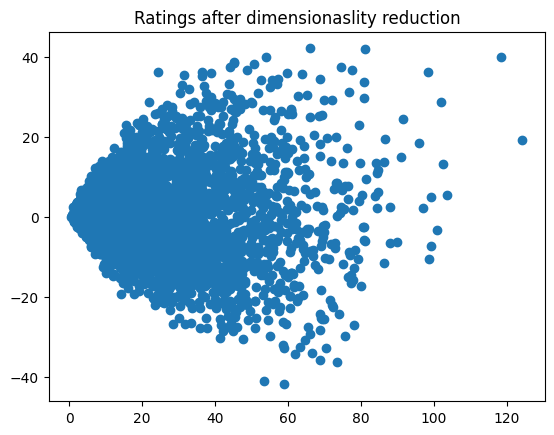

In [36]:
plt.scatter(ratings_transformed_2.T[0],
            ratings_transformed_2.T[1])
plt.title('Ratings after dimensionaslity reduction')
plt.show()

As we can see, even the first two components already abse to explain more than 17% of variance in the data, but there is still a lot of the valuable changes beside these two components. So if we would analyze the data based on this decomposition, we likely should take more compoments into account.

To determine if there are any clear groupings in the data, let's try to cluster this data with Agglomerative clustering, as it will quickly determine the number of clusters automatically from the data, and thus can give us more important insight.

In [37]:
from sklearn.cluster import AgglomerativeClustering

In [43]:
clustering_2 = AgglomerativeClustering().fit(ratings_transformed_2)

In [44]:
len(clustering_2.labels_)

6040

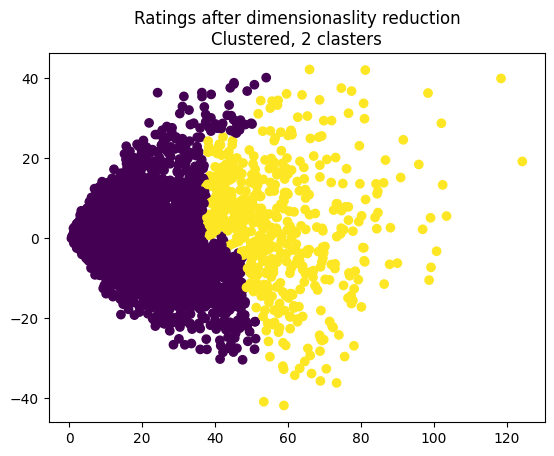

In [58]:
plt.scatter(ratings_transformed_2.T[0],
            ratings_transformed_2.T[1],
            c=clustering_2.labels_)
plt.title(f'Ratings after dimensionaslity reduction\nClustered, {clustering_2.n_clusters_} clasters')
plt.show()

As we can see from the users clustering plot by their raw rankings, the edges between the clusters are not very pronounced in the data. However, there are a lot of outliers. Therefore, thrre definitely are some gradual changes in the nature of the users, but there are no well-defined groups among them.

This can also be due to the faxt that we have also used 2 main PCA components, and even though they describe a significant amount of the variation in the data, they can explain not all the small changes differing the user groups. Let’s use more components and observe what changes:

In [113]:
svd_20 = TruncatedSVD(n_components=20,
                   random_state=5)

In [114]:
svd_20.fit(sparse_ratings)

TruncatedSVD(n_components=20, random_state=5)

In [115]:
print(f'--Explained variance: {svd_20.explained_variance_ratio_}, total: {svd_20.explained_variance_ratio_.sum():.5f}')

--Explained variance: [0.1351055  0.03729351 0.02731826 0.02040073 0.01553537 0.01480778
 0.01313097 0.00983884 0.00930807 0.00815016 0.00691208 0.00628225
 0.00543671 0.00529932 0.00498527 0.00471332 0.00442305 0.00403278
 0.00379217 0.00374719], total: 0.34051


In [116]:
ratings_transformed_20 = svd_20.transform(sparse_ratings)

In [117]:
clustering_20 = AgglomerativeClustering().fit(ratings_transformed_20)

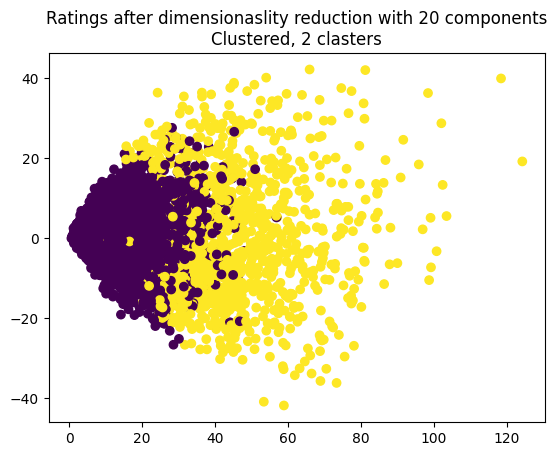

In [118]:
plt.scatter(ratings_transformed_20.T[0],
            ratings_transformed_20.T[1],
            c=clustering_20.labels_)
plt.title(f'Ratings after dimensionaslity reduction with 20 components\nClustered, {clustering_2.n_clusters_} clasters')
plt.show()

As we can see, the clusters have mostly remained close to the same centroids and general areas. The borders have obviously become more diffused at the plot. This highlights how our clustering was stable and there are some patterns in the user data, even though they may not fully separate into clear-defined groups and have a lot of users in-between.

Another possible reason is that the user grouping actually depends on the more complex characteristics, like the number of user’s ratings, genre of the movies they rate the most, or the average of rating for different genres. We will try to uncover such dependencies the the users analysis below.

Not, let’s similarly do the dimensionality reduction and clustering for items by their rankings:


In [59]:
svd = TruncatedSVD(n_components=2,
                   random_state=5)

In [60]:
svd.fit(sparse_ratings.T)

TruncatedSVD(random_state=5)

In [61]:
print(f'--Explained variance: {svd.explained_variance_ratio_}, total: {svd.explained_variance_ratio_.sum():.5f}')

--Explained variance: [0.18879645 0.034936  ], total: 0.22373


In [62]:
ratings_transformed_2 = svd.transform(sparse_ratings.T)

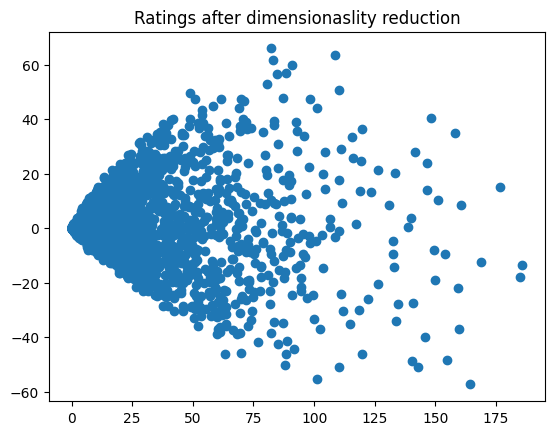

In [63]:
plt.scatter(ratings_transformed_2.T[0],
            ratings_transformed_2.T[1])
plt.title('Ratings after dimensionaslity reduction')
plt.show()

Item-wise dimensionality reduction provides very close results to the user-wise reduction, but here the data seems more organised into subcategories, and even here we can see some at the well-defined groups. Even more interesting to look at the clustering for it:

In [69]:
clustering_2 = AgglomerativeClustering().fit(ratings_transformed_2)

In [70]:
len(clustering_2.labels_)

3952

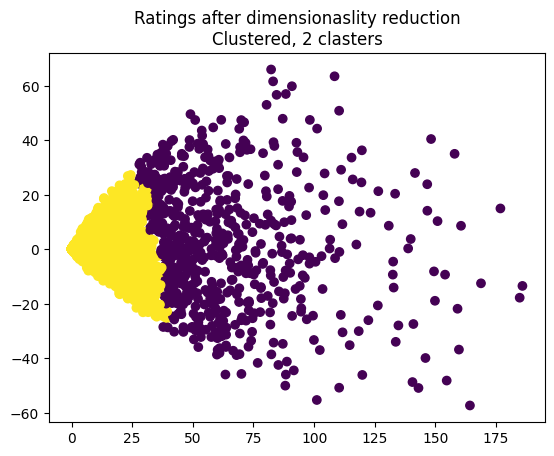

In [71]:
plt.scatter(ratings_transformed_2.T[0],
            ratings_transformed_2.T[1],
            c=clustering_2.labels_)
plt.title(f'Ratings after dimensionaslity reduction\nClustered, {clustering_2.n_clusters_} clasters')
plt.show()

And here the data has some more well-defined groups! It is likely that the movies have more defined constraints, and they have more differences between the user groups that rate them. I.e., the user that likes the sci-fi movies the most will most likely also rate other movies and have either positive or negative opinions on them, while less popular sci-fi movies are more likle to be viewed just by sci-fi fans and be low-rated by the occasional other users.

Let’s also see if such a clustering split here preserves for the 20-component data:

In [72]:
svd_20 = TruncatedSVD(n_components=20,
                   random_state=5)

In [74]:
svd_20.fit(sparse_ratings.T)

TruncatedSVD(n_components=20, random_state=5)

In [75]:
print(f'--Explained variance: {svd_20.explained_variance_ratio_}, total: {svd_20.explained_variance_ratio_.sum():.5f}')

--Explained variance: [0.18879645 0.034936   0.02563381 0.01922047 0.01453336 0.01374507
 0.01174876 0.00932594 0.00873848 0.00774745 0.00647703 0.00591765
 0.00510016 0.00496188 0.00467067 0.00444786 0.00415238 0.00380601
 0.00357314 0.00349668], total: 0.38103


For the item-wise data, the share of explained variance is already climbing more steadily here than for the users, suggesting that a few of the first components here are a bit more influental (as we can also see on the explained variance value for the respective components themselves).

In [77]:
ratings_transformed_20 = svd_20.transform(sparse_ratings.T)

In [78]:
clustering_20 = AgglomerativeClustering().fit(ratings_transformed_20)

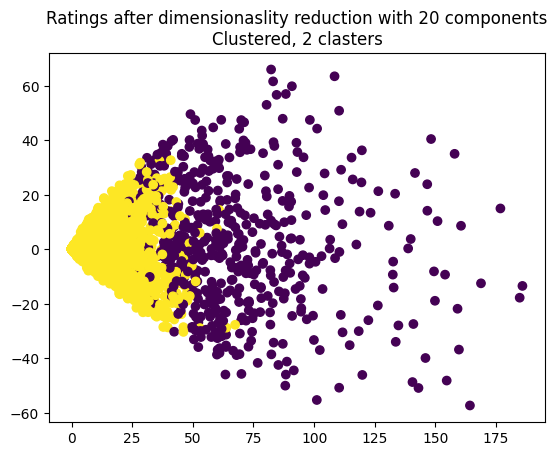

In [79]:
plt.scatter(ratings_transformed_20.T[0],
            ratings_transformed_20.T[1],
            c=clustering_20.labels_)
plt.title(f'Ratings after dimensionaslity reduction with 20 components\nClustered, {clustering_2.n_clusters_} clasters')
plt.show()

The general tendency from the users preserves here.

### User-rating analysis

Let’s analyze the properties of the ratings user-wise, starting with calculating the average rankings:

In [94]:
avg_rating_user = df_ratings.groupby('UserID').mean()['Rating']

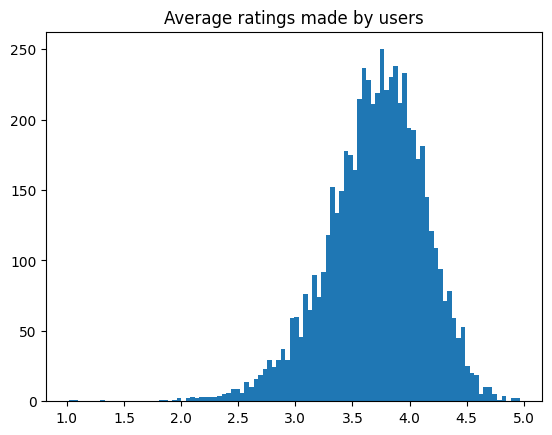

In [95]:
plt.hist(avg_rating_user,
         bins=100)
plt.title('Average ratings made by users')
plt.show()

As we can see, the general distribution of the average ratings made by the users is close to the normal distribution, and absolute most the averages are above 2.5. Still, there are several clear outliers below 2.0, one group of which is essentially the average 1.0. Given that we have only user with 20 or more reviews in our data, that is likely an indication of some agenda in the user's votes or a possibility that he registered on the rating website with a goal to downrate certain movies.

As all of these outliers can be caused by the fact that the users have rated only several movies, let’s look at the total number of ratings:


In [97]:
number_rating_user = df_ratings.groupby('UserID').count()['Rating']

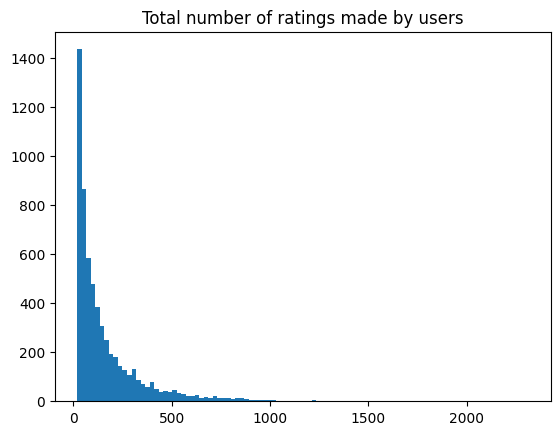

In [98]:
plt.hist(number_rating_user,
         bins=100)
plt.title('Total number of ratings made by users')
plt.show()

As we can see, it follows exponential distribution starting from 20. This shows that there no irregular values in the number of ratings, but some of the users are indeed the dedicated raters who made much more rates.

But more patterns can be discovered from comparing the count with the average ratings. Are the dedicated users rating the in other way, than the more casual ones?


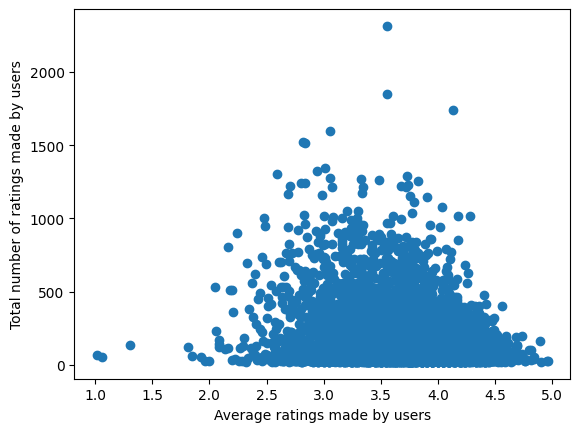

In [99]:
plt.scatter(avg_rating_user,
            number_rating_user)
plt.xlabel('Average ratings made by users')
plt.ylabel('Total number of ratings made by users')
plt.show()

Predictably, most of the outlier points resulted from less ratings. The most interesting detail here is the fact that the absolute most of the average ratings below 3.4 are for the users who rated a very low number of movies. It indicates that there can be some subset of either negatively-minded users that only watched a few of the movies, but also it is likely that they specifically downrated some of the movies. It is also possible that some users then to rate movies more exremely, as either very good or very bad, but they are unlikely to be really knowledgeable in the cinema industry.

Another curious fact is that there definitely is a small dedicated group of users which have rated only a few movies, but almost all of them are 1.0. This is clearly a well-defined group of “negative voters”.

A thing worth taking in mind is the fact that our dataset only has the users with 20 or more rankings. In real application there would likely be many distributional anomalies produced with users wiyh only a few ratings.

Now, there is another variable we haven’t explored yet - time. It can be a very powerful measure to explain the users behaviour.

Let’s review the users’ activity time on the platform in minutes by taking the difference between their min and max rating:

In [102]:
activity_time_user = (df_ratings.groupby('UserID')['Timestamp'].max() - df_ratings.groupby('UserID')[
                      'Timestamp'].min())/60

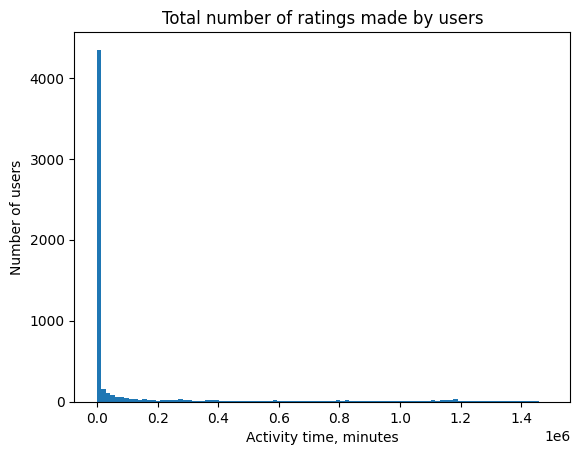

In [106]:
plt.hist(activity_time_user,
         bins=100)
plt.title('Total number of ratings made by users')
plt.xlabel('Activity time, minutes')
plt.ylabel('Number of users')
plt.show()

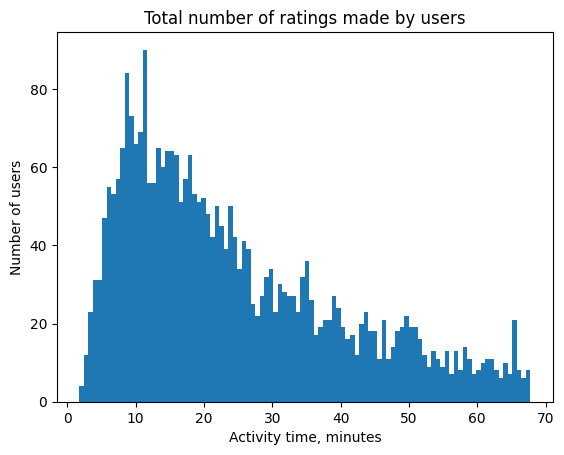

In [107]:
plt.hist(activity_time_user[activity_time_user < activity_time_user.quantile(0.5)],
         bins=100)
plt.title('Total number of ratings made by users')
plt.xlabel('Activity time, minutes')
plt.ylabel('Number of users')
plt.show()

Here we can see another effect of the 20-rating-min dataset capping - otherwise this most liky would’ve been an ecponential plot.

But here we can clearly see two types of users. First ones usually make only a single activity window in a single day. In fact, almost 50% of all of the users have spent a total of just an hour or less making all of the ratings, and the median is just above it:


In [108]:
activity_time_user.quantile(0.5)

67.80833333333334

The other group has their bordering ratings over a long period of time, often several yesra. These are clearly the dedicated users of a platform, who return again and again to make the ratings.

It would be interesting to explore how the two groups’ behavior differs. Does the second one make much more ratings, or the first one is able to catch up to it in a short period of time? Let’s compare them.

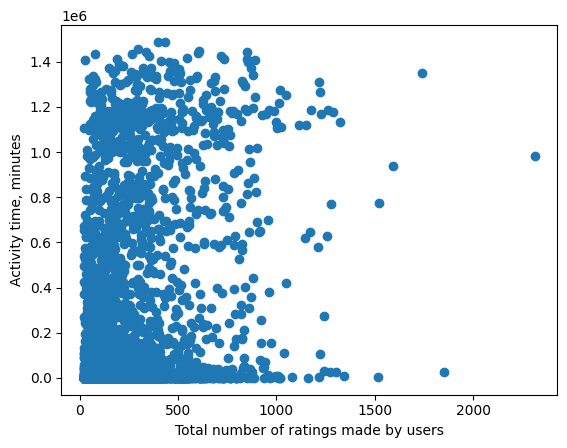

In [109]:
plt.scatter(number_rating_user,
            activity_time_user)
plt.ylabel('Activity time, minutes')
plt.xlabel('Total number of ratings made by users')
plt.show()

This plot demonstrates that there are some users, who have a short rate span, and yet manage a quite high number of rates.

One interesting thing to review here would be where on this plot are the previously defined user clasters. Let’s plot them:

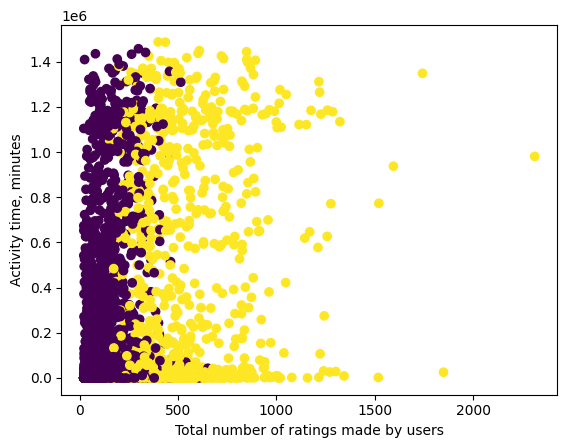

In [119]:
plt.scatter(number_rating_user,
            activity_time_user,
            c=clustering_20.labels_)
plt.ylabel('Activity time, minutes')
plt.xlabel('Total number of ratings made by users')
plt.show()

And indeed, the clusters do correspond to the well-defined regions on the plot. For example, the biggest present cluster clearly corresponds to the points from the low exponebtially distributed area, and there are some regions with high ratings count and yet short total activity time.

This points out to us that we’ve discovered the first property that is truly predictive for the calculated clusters, and this characteristic is rating speed. Let’s build the histograms of rating speed for the different clusters to visually review the clusters and confirm that it is important for the users differentiation:


In [120]:
speed_user = number_rating_user / activity_time_user

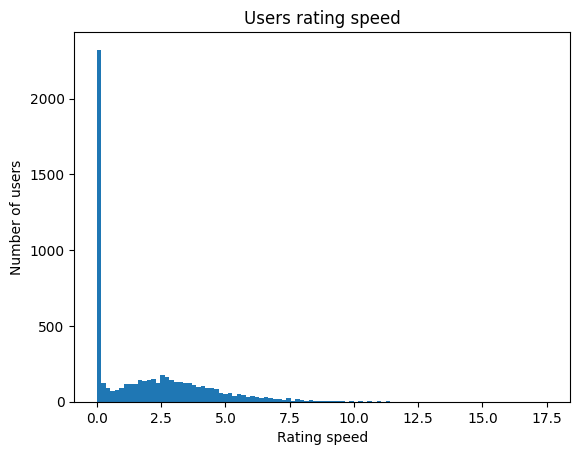

In [122]:
plt.hist(speed_user,
         bins=100)
plt.title('Users rating speed')
plt.xlabel('Rating speed')
plt.ylabel('Number of users')
plt.show()

We can clearly see two groups of points on the speed plot straight away! Let's further expand on this:

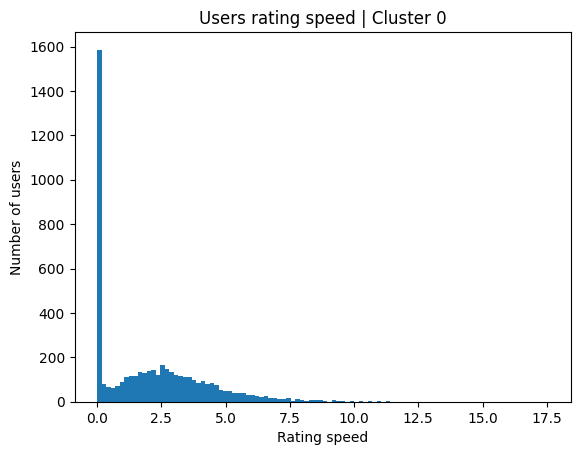

In [131]:
plt.hist(speed_user.iloc[np.where(clustering_20.labels_ == 0)],
         bins=100)
plt.title('Users rating speed | Cluster 0')
plt.xlabel('Rating speed')
plt.ylabel('Number of users')
plt.show()

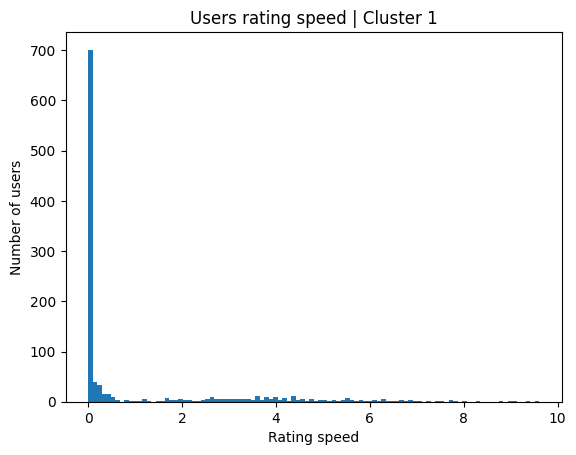

In [132]:
plt.hist(speed_user.iloc[np.where(clustering_20.labels_ == 1)],
         bins=100)
plt.title('Users rating speed | Cluster 1')
plt.xlabel('Rating speed')
plt.ylabel('Number of users')
plt.show()

Both clusters indeed have very different rating speed distribution. The cluster 0 likely indicates the users that were in it have possibly used only a short time to visit the website, while the cluster 1 indicated that they most likely spent more time ijn it with several sessions. At the same time, these conditions are far from defined as both cluseters have both types of points. They should have other defining characteristics, possibly this time possibly related to the ratings values themselves. Let’s similarly visualize average ratings per cluster:

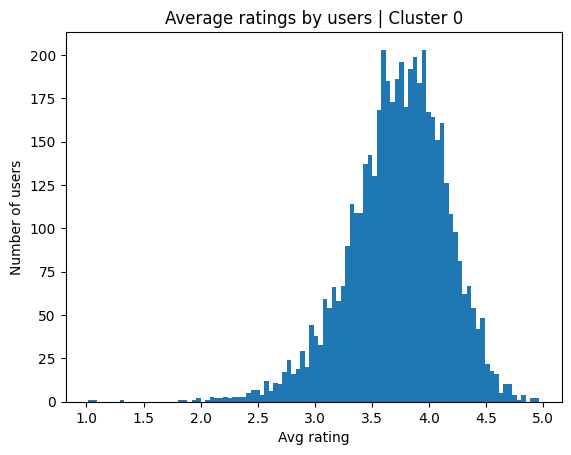

In [133]:
plt.hist(avg_rating_user.iloc[np.where(clustering_20.labels_ == 0)],
         bins=100)
plt.title('Average ratings by users | Cluster 0')
plt.xlabel('Avg rating')
plt.ylabel('Number of users')
plt.show()

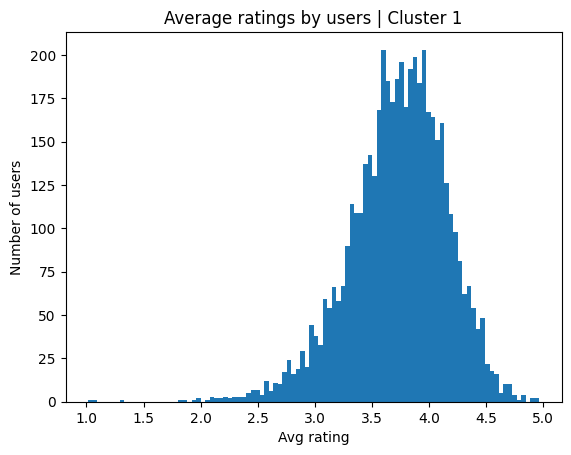

In [134]:
plt.hist(avg_rating_user.iloc[np.where(clustering_20.labels_ == 0)],
         bins=100)
plt.title('Average ratings by users | Cluster 1')
plt.xlabel('Avg rating')
plt.ylabel('Number of users')
plt.show()

As we can see from the histograms, their distrivutions are almost the same for the both classes.

Now, to complete the time-wise analysis, let’s compare the total activity time with the users’ average rating:


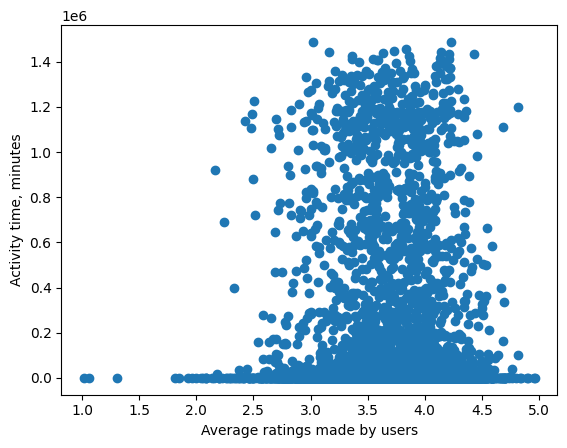

In [111]:
plt.scatter(avg_rating_user,
            activity_time_user)
plt.ylabel('Activity time, minutes')
plt.xlabel('Average ratings made by users')
plt.show()

The resulting plot is very similar to the one comparing total activity time with the total number of ratings. This is predictable, because, as shown earlier, the two variable have a very pronounced backward dependency.

Now, let’s also compare the rating speed with the average ratings. This plot will answer the question, whether the quick way the users are doing the rating is influencing their scores, and whether they possibly aim to give most of the movies either high or low rates during their quick voting windows.

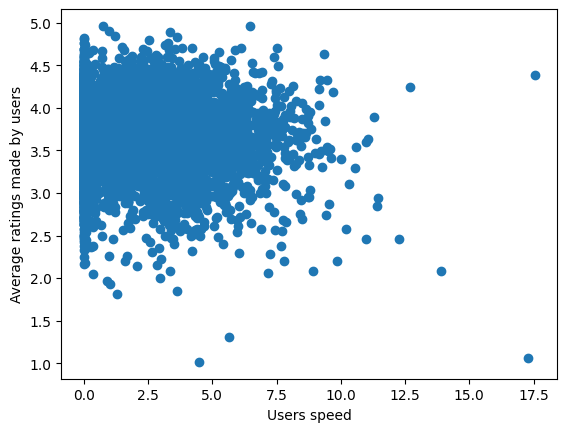

In [139]:
plt.scatter(speed_user,
            avg_rating_user)
plt.xlabel('Users speed')
plt.ylabel('Average ratings made by users')
plt.show()

This plot has produced a few very interesting insights: the outliers by the average rating often have higher speed.

Let's also plot speed vs total time:

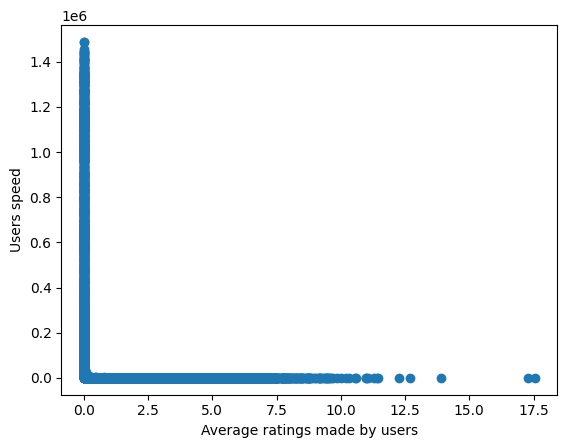

In [137]:
plt.scatter(speed_user,
            activity_time_user)
plt.ylabel('Users speed')
plt.xlabel('Average ratings made by users')
plt.show()

As we can see, the range of points in this plot is largely limited by the naturally impossible ability to rate the movies faster than a certain speed. The hard cutoff of the values can be explained by the fact that the values below 20 are not in the data. The users with the high rating speed do not have a lot of time spent for obvious reasons.

Now that we’ve analyzed the properties of the users’ ratings, let’s analyze the items’ ratings.

### Item-rating analysis

Let’s start from the same point - by calculating the average rating for each item. Here we expect more groupings than for the users’ ratings for the movies the public has a general opinion upon.

In [140]:
avg_rating_it = df_ratings.groupby('MovieID').mean()['Rating']

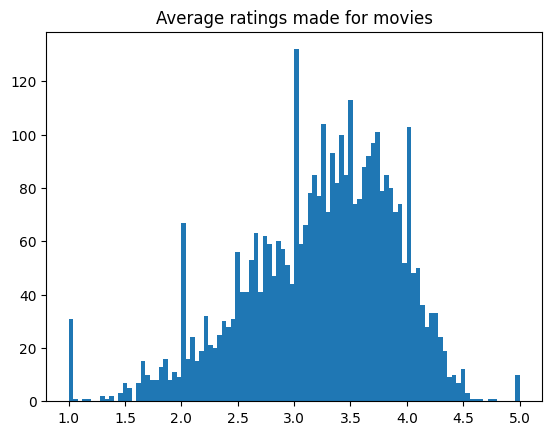

In [141]:
plt.hist(avg_rating_it,
         bins=100)
plt.title('Average ratings made for movies')
plt.show()

In [143]:
number_rating_it = df_ratings.groupby('MovieID').count()['Rating']

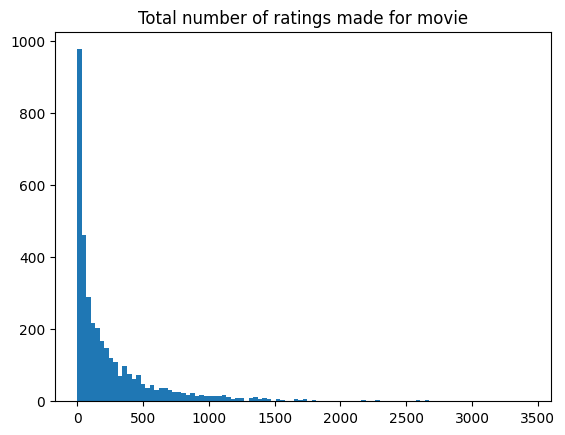

In [144]:
plt.hist(number_rating_it,
         bins=100)
plt.title('Total number of ratings made for movie')
plt.show()

## User analysis

Let’s start by reviewing the users’ age:



In [145]:
df_users = pd.read_csv('../../data/ml-1m/users.dat',
                         delimiter='::',
                         header=None,
                         names=['UserID','Gender','Age','Occupation','Zip-code'])

/tmp/ipykernel_99451/1069005882.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_users = pd.read_csv('../../data/ml-1m/users.dat',


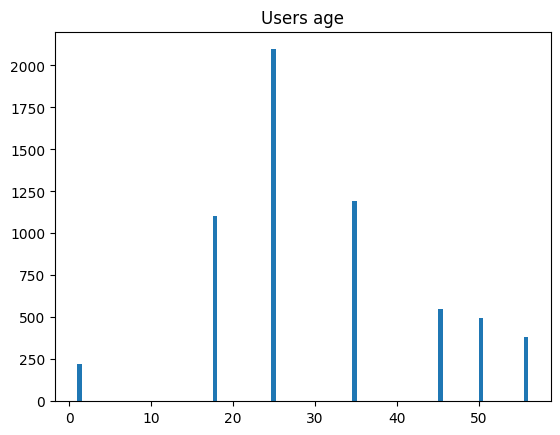

In [148]:
plt.hist(df_users['Age'],
         bins=100)
plt.title('Users age')
plt.show()

Here we can notice some irregularities. Users can most definitely not be of the age 1 - this a usual follow-up of the fields generated by the user input. Most likely, these were the first available most convenient values. If we include age in some of our models, these values can skew the training and the resulting metrics, so they should be treated as the missing values.

**All of the below info was lost die to the unfortnate GIT rebase.**

Now, are the different age groups rating the movies differently?

– Scatter age - avg rating

A very interesting thing to view here are the age distributions depending on the genre. This is where age groups should become particularly important.

– Movie genre-wise histograms of users’ age

And are people of different ages more likly to quickly rate all of the movies they want and never return to the website again? Are the users who rate movies consistently over a long period of time distributed the same across all of the ages?

– Scatter age - rating speed

Now having reviewed most age-related characteristics, let’s review how many users of any occupations are there.

– Occupation bar plot

– Occupation-wise histograms of users’ age

And do the people of different occupations produce different ratings on average?

– Occupation-wise histograms of users’ average ratings

And are people of some occupation producing more ratings and more active on average? Maybe, some people watch more movies due to it being close to the line of their work; or people of a certain occupation are more likely to watch and rate a lot of movies? The plot of total number of ratings by users of each occupation will help us:

– Occupation-wise histograms of users’ total number of ratings

– Occupation-wise histograms of users’ rating speed

Are people of different occupations rating different movie genres differently? Are there some genres that are uniquely most popular among people of a certain occupation? Let’s find out:

– Occupation-wise bar plots of average ratings for each genre

## Item analysis

The movies doesn’t really have a lot of columns useful for our analysis, as the titles are not very indicative of anything. It doesn’t even help the movies release dates and years, which would’ve been helpful in understanding patterns in the movie-wise data more.

So, the only variable available for analysis here are the movie genre. It was already partially reviewed in the previous sections, but there still are some things for us to look at.

Let’s visualize the overall distribution of movies by their genre in the data:

– Movie genre bar plot

And let’s see how each genre is rated on average:

– Movie genre-wise avg bar plot

It will be also interesting to look how much each genre is covered by ratings. Let’s build for this purpose a plot of average number of rating per movie for each genre:

– Movie genre-wise average number of ratings per movie

And also, repeating a bit our user age exploration from a different angle, let’s plot the average age of raters of the movies of each genre, which will allow us to order them:

– Movie genre-wise users’ average age
